## 1. imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, auc, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline, Pipeline
import shap

## 2. data preprocessing

In [7]:
df = pd.read_csv('breast_cancer_dataset.csv')
df = df.drop(columns=['ID'])
print(df.head())
# 1: mean
# 2: standard error
# 3: worst

  Diagnosis  radius1  texture1  perimeter1   area1  smoothness1  compactness1  \
0         M    17.99     10.38      122.80  1001.0      0.11840       0.27760   
1         M    20.57     17.77      132.90  1326.0      0.08474       0.07864   
2         M    19.69     21.25      130.00  1203.0      0.10960       0.15990   
3         M    11.42     20.38       77.58   386.1      0.14250       0.28390   
4         M    20.29     14.34      135.10  1297.0      0.10030       0.13280   

   concavity1  concave_points1  symmetry1  ...  radius3  texture3  perimeter3  \
0      0.3001          0.14710     0.2419  ...    25.38     17.33      184.60   
1      0.0869          0.07017     0.1812  ...    24.99     23.41      158.80   
2      0.1974          0.12790     0.2069  ...    23.57     25.53      152.50   
3      0.2414          0.10520     0.2597  ...    14.91     26.50       98.87   
4      0.1980          0.10430     0.1809  ...    22.54     16.67      152.20   

    area3  smoothness3  co

In [8]:
# number of each class
print(df['Diagnosis'].value_counts())

Diagnosis
B    357
M    212
Name: count, dtype: int64


In [9]:
# train test split
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis'].replace({'M': 1, 'B': 0})

/var/folders/z2/_0c1fw_d62gfdmm0hfw2lfpr0000gn/T/ipykernel_84566/1901172651.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Diagnosis'].replace({'M': 1, 'B': 0})


### 2.1  0.7/0.3 split

In [10]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 2.2 using only mean data

In [11]:
# get all columns that have 1 in column name
mean_df_x = df.filter(like='1')
mean_df_y = df['Diagnosis'].replace({'M': 1, 'B': 0})
# train test split
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(mean_df_x, mean_df_y, test_size=0.3, random_state=42)

/var/folders/z2/_0c1fw_d62gfdmm0hfw2lfpr0000gn/T/ipykernel_84566/3440945245.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mean_df_y = df['Diagnosis'].replace({'M': 1, 'B': 0})


## 3. Models

In [12]:
# stratified k fold evaluation 
def evaluate_model_cv(model, X, y, model_name="Model", n_splits=5):
    """
    Evaluates a model using Stratified K-Fold Cross-Validation.
    
    Parameters:
        model: sklearn estimator (e.g. LogisticRegression())
        X: pandas DataFrame or NumPy array of features
        y: pandas Series or NumPy array of labels
        model_name: name string for printing
        n_splits: number of folds (default = 5)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    accuracies = []
    aucs = []

    print(f"\n📊 Evaluating {model_name} with {n_splits}-Fold Stratified CV")

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        auc_score = roc_auc_score(y_test, y_pred)

        accuracies.append(acc)
        aucs.append(auc_score)

        print(f"Fold {fold} Accuracy: {acc:.4f}, AUC: {auc_score:.4f}")
        print(classification_report(y_test, y_pred))

    print(f"\n✅ {model_name} Results Across Folds")
    print(f"Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"Average AUC: {np.mean(aucs):.4f}")
    return accuracies, aucs

### 3.1 Logistic Regression

In [16]:
lr = LogisticRegression(max_iter=1000)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report: \n", classification_report(y_test, y_pred))
print("Logistic Regression Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Logistic Regression ROC AUC Score: ", roc_auc_score(y_test, y_pred))


Accuracy:  0.9824561403508771
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       108
           1       0.97      0.98      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

Logistic Regression Confusion Matrix: 
 [[106   2]
 [  1  62]]
Logistic Regression ROC AUC Score:  0.9828042328042329


#### 3.1.1 Grid Search

In [7]:
# grid search for hyperparameter tuning
# grid search for hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500, 1000]
}
lr = LogisticRegression()
grid_search_lr = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_
print("Best Logistic Regression parameters: ", grid_search_lr.best_params_)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

Best Logistic Regression parameters:  {'C': 100, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}


In [17]:
lr = LogisticRegression(max_iter=1000, C=100, penalty='l1', solver='liblinear')

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Logistic Regression Accuracy: ", accuracy_score(y_test, y_pred))
print("Logistic Regression Classification Report: \n", classification_report(y_test, y_pred))
print("Logistic Regression Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Logistic Regression ROC AUC Score: ", roc_auc_score(y_test, y_pred))


Logistic Regression Accuracy:  0.9473684210526315
Logistic Regression Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.93      0.96       108
           1       0.89      0.98      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.96      0.94       171
weighted avg       0.95      0.95      0.95       171

Logistic Regression Confusion Matrix: 
 [[100   8]
 [  1  62]]
Logistic Regression ROC AUC Score:  0.955026455026455


#### 3.1.2 Mean Columns

In [ ]:
# fit and predict with only mean columns
lr = LogisticRegression(max_iter=1000, C=100, penalty='l1', solver='liblinear')

lr.fit(X_train_mean, y_train_mean)
y_pred_mean = lr.predict(X_test_mean)

print("Accuracy: ", accuracy_score(y_test_mean, y_pred_mean))
print("Classification Report: \n", classification_report(y_test_mean, y_pred_mean))
print("Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_mean))
print("ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_mean))

Accuracy:  0.9473684210526315
Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       108
           1       0.94      0.92      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

Confusion Matrix: 
 [[104   4]
 [  5  58]]
ROC AUC Score:  0.9417989417989417


#### 3.1.3 Stratified K Fold

In [27]:
acc_lr, auc_lr = evaluate_model_cv(LogisticRegression(max_iter=1000, C=100, penalty='l1', solver='liblinear'),
                  X, y, model_name="Logistic Regression")


📊 Evaluating Logistic Regression with 5-Fold Stratified CV
Fold 1 Accuracy: 0.9298, AUC: 0.9299
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        71
           1       0.89      0.93      0.91        43

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114

Fold 2 Accuracy: 0.9561, AUC: 0.9510
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

Fold 3 Accuracy: 0.9211, AUC: 0.9177
              precision    recall  f1-score   support

           0       0.94      0.93      0.94        72
           1       0.88      0.90      0.89        42

    accurac

#### 3.1.4 Shap

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


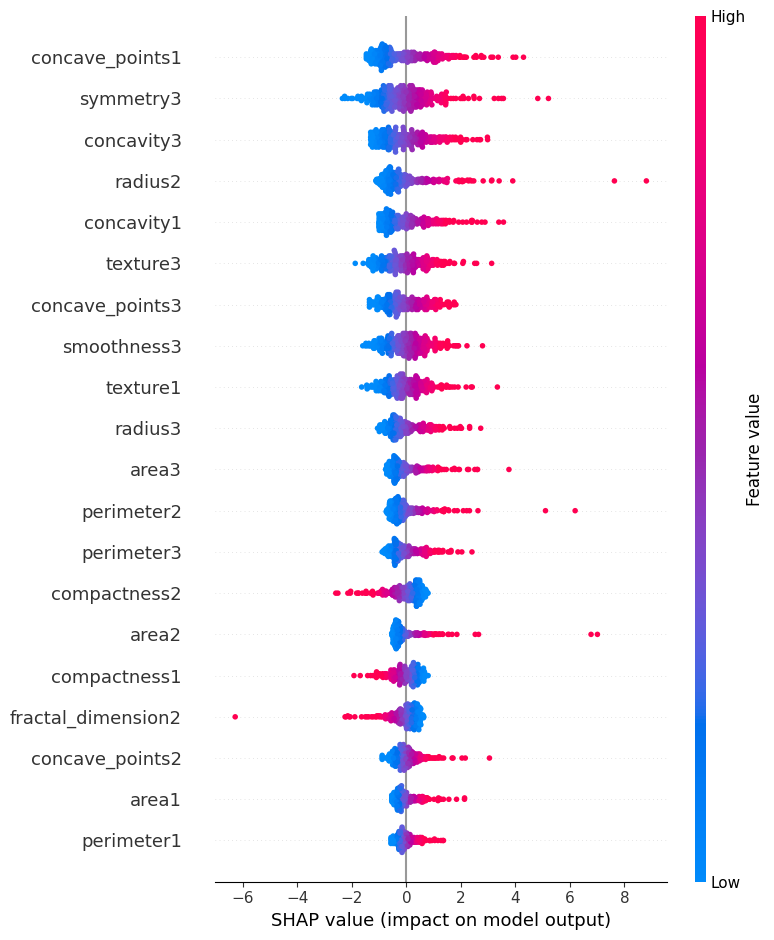

In [53]:
explainer = shap.LinearExplainer(lr, X_train, feature_perturbation="interventional")
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

### 3.2 Random Forest

In [60]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Accuracy: ", accuracy_score(y_test, y_pred))
print("Random Forest Classification Report: \n", classification_report(y_test, y_pred))
print("Random Forest Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Random Forest ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Random Forest Accuracy:  0.9649122807017544
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       108
           1       0.98      0.92      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.97      0.96      0.96       171

Random Forest Confusion Matrix: 
 [[107   1]
 [  5  58]]
Random Forest ROC AUC Score:  0.9556878306878306


#### 3.2.1 Grid Search

In [10]:
# grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest parameters: ", grid_search_rf.best_params_)

Best Random Forest parameters:  {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.

In [21]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Random Forest Accuracy: ", accuracy_score(y_test, y_pred))
print("Random Forest Classification Report: \n", classification_report(y_test, y_pred))
print("Random Forest Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Random Forest ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Random Forest Accuracy:  0.9649122807017544
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       108
           1       0.97      0.94      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171

Random Forest Confusion Matrix: 
 [[106   2]
 [  4  59]]
Random Forest ROC AUC Score:  0.958994708994709


#### 3.2.2 Mean Columns

In [ ]:
# fit and predict with only mean columns
rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt')
rf.fit(X_train_mean, y_train_mean)
y_pred_mean = rf.predict(X_test_mean)
print("Random Forest Accuracy: ", accuracy_score(y_test_mean, y_pred_mean))
print("Random Forest Classification Report: \n", classification_report(y_test_mean, y_pred_mean))
print("Random Forest Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_mean))
print("Random Forest ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_mean))

Random Forest Accuracy:  0.9415204678362573
Random Forest Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Random Forest Confusion Matrix: 
 [[103   5]
 [  5  58]]
Random Forest ROC AUC Score:  0.9371693121693121


#### 3.2.3 Stratified K Fold

In [29]:
acc_rf, auc_rf = evaluate_model_cv(RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt'),
                  X, y, model_name="Random Forest")


📊 Evaluating Random Forest with 5-Fold Stratified CV
Fold 1 Accuracy: 0.9649, AUC: 0.9672
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Fold 2 Accuracy: 0.9386, AUC: 0.9232
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        71
           1       0.97      0.86      0.91        43

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

Fold 3 Accuracy: 0.9474, AUC: 0.9335
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        72
           1       0.97      0.88      0.93        42

    accuracy     

#### 3.2.4 SHAP

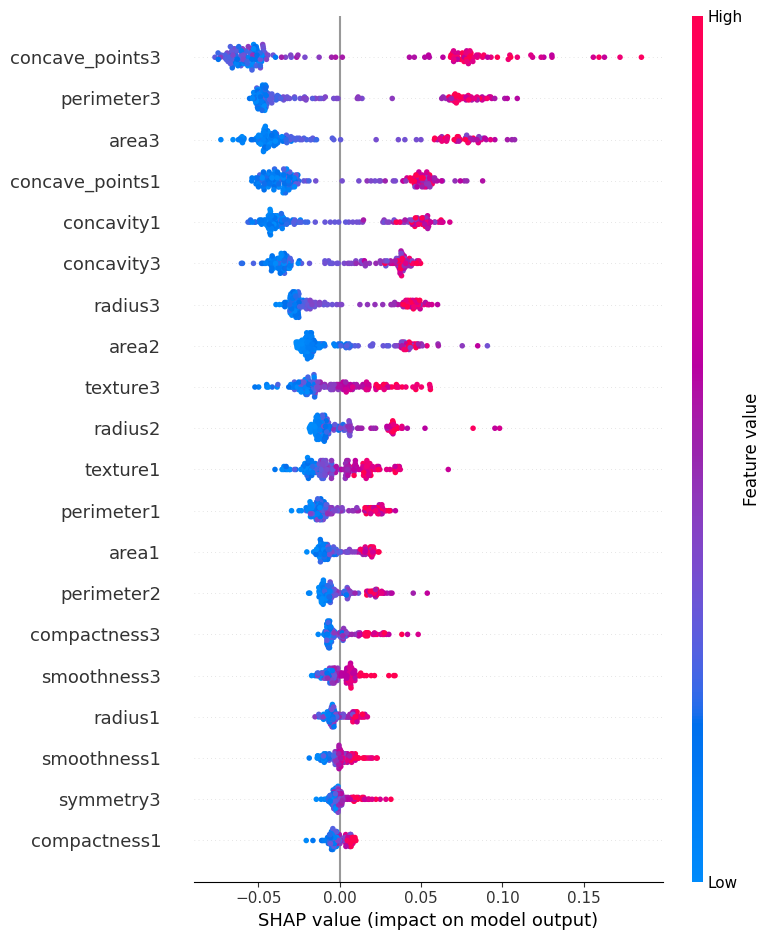

In [66]:
# Create SHAP explainer for the model
explainer_rf = shap.Explainer(rf, X_train)
shap_values_rf = explainer_rf(X_test, check_additivity=False)

# Plot summary of feature importance
shap.summary_plot(shap_values_rf[..., 1], X_test, feature_names=X.columns)  # class 1 = malignant

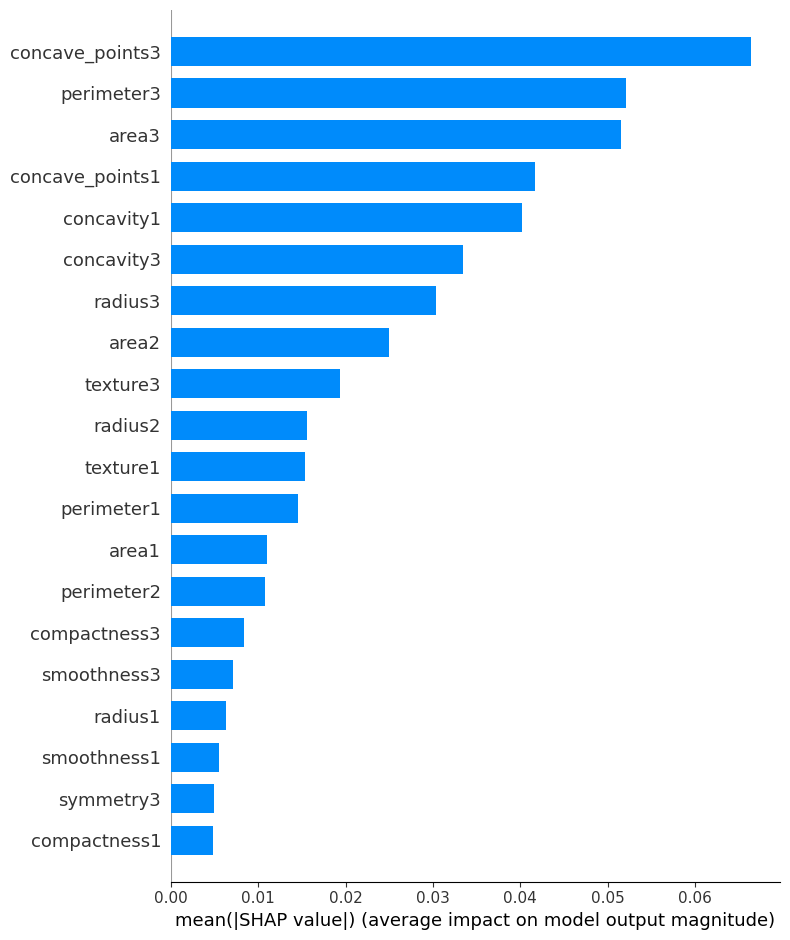

In [67]:
shap.summary_plot(shap_values_rf[..., 1], X_test, plot_type="bar", feature_names=X.columns)

### 3.3 Decision Tree

In [68]:
# before fine tuning
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Decision Tree Accuracy: ", accuracy_score(y_test, y_pred))
print("Decision Tree Classification Report: \n", classification_report(y_test, y_pred))
print("Decision Tree Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Decision Tree ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Decision Tree Accuracy:  0.9064327485380117
Decision Tree Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       108
           1       0.83      0.94      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171

Decision Tree Confusion Matrix: 
 [[96 12]
 [ 4 59]]
Decision Tree ROC AUC Score:  0.9126984126984127


#### 3.3.1 Grid Search

In [13]:
# grid search for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier()
grid_search_dt = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)
best_dt = grid_search_dt.best_estimator_
print("Best Decision Tree parameters: ", grid_search_dt.best_params_)

Best Decision Tree parameters:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}


In [22]:
dt = DecisionTreeClassifier(random_state=42, min_samples_split=5, min_samples_leaf=4, max_features='log2', criterion='gini')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Decision Tree Accuracy: ", accuracy_score(y_test, y_pred))
print("Decision Tree Classification Report: \n", classification_report(y_test, y_pred))
print("Decision Tree Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Decision Tree ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Decision Tree Accuracy:  0.9415204678362573
Decision Tree Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Decision Tree Confusion Matrix: 
 [[103   5]
 [  5  58]]
Decision Tree ROC AUC Score:  0.9371693121693121


#### 3.3.2 Mean Columns

In [ ]:
# fit and predict with only mean columns
dt = DecisionTreeClassifier(random_state=42, min_samples_split=5, min_samples_leaf=4, max_features='log2', criterion='gini')
dt.fit(X_train_mean, y_train_mean)
y_pred_mean = dt.predict(X_test_mean)
print("Decision Tree Accuracy: ", accuracy_score(y_test_mean, y_pred_mean))
print("Decision Tree Classification Report: \n", classification_report(y_test_mean, y_pred_mean))
print("Decision Tree Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_mean))
print("Decision Tree ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_mean))

Decision Tree Accuracy:  0.9532163742690059
Decision Tree Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Decision Tree Confusion Matrix: 
 [[106   2]
 [  6  57]]
Decision Tree ROC AUC Score:  0.943121693121693


#### 3.3.3 Stratified K Fold

In [30]:
acc_dt, auc_dt = evaluate_model_cv(DecisionTreeClassifier(random_state=42, min_samples_split=5, min_samples_leaf=4, max_features='log2', criterion='gini'),
                  X, y, model_name="Decision Tree")


📊 Evaluating Decision Tree with 5-Fold Stratified CV
Fold 1 Accuracy: 0.9386, AUC: 0.9461
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        71
           1       0.88      0.98      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.95      0.94       114
weighted avg       0.94      0.94      0.94       114

Fold 2 Accuracy: 0.9123, AUC: 0.8883
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        71
           1       0.97      0.79      0.87        43

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114

Fold 3 Accuracy: 0.9298, AUC: 0.9097
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        72
           1       0.97      0.83      0.90        42

    accuracy     

#### 3.3.4 Shap

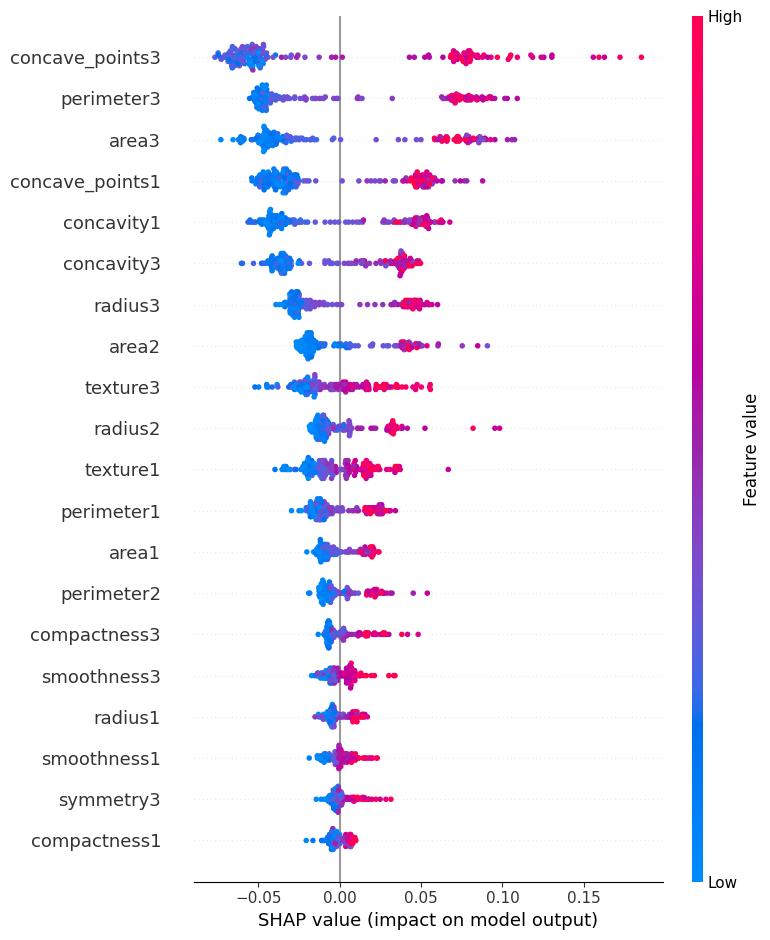

In [70]:
# Create SHAP explainer for the model
explainer_dt = shap.Explainer(dt, X_train)
shap_values_dt = explainer_rf(X_test, check_additivity=False)

# Plot summary of feature importance
shap.summary_plot(shap_values_dt[..., 1], X_test, feature_names=X.columns)  # class 1 = malignant

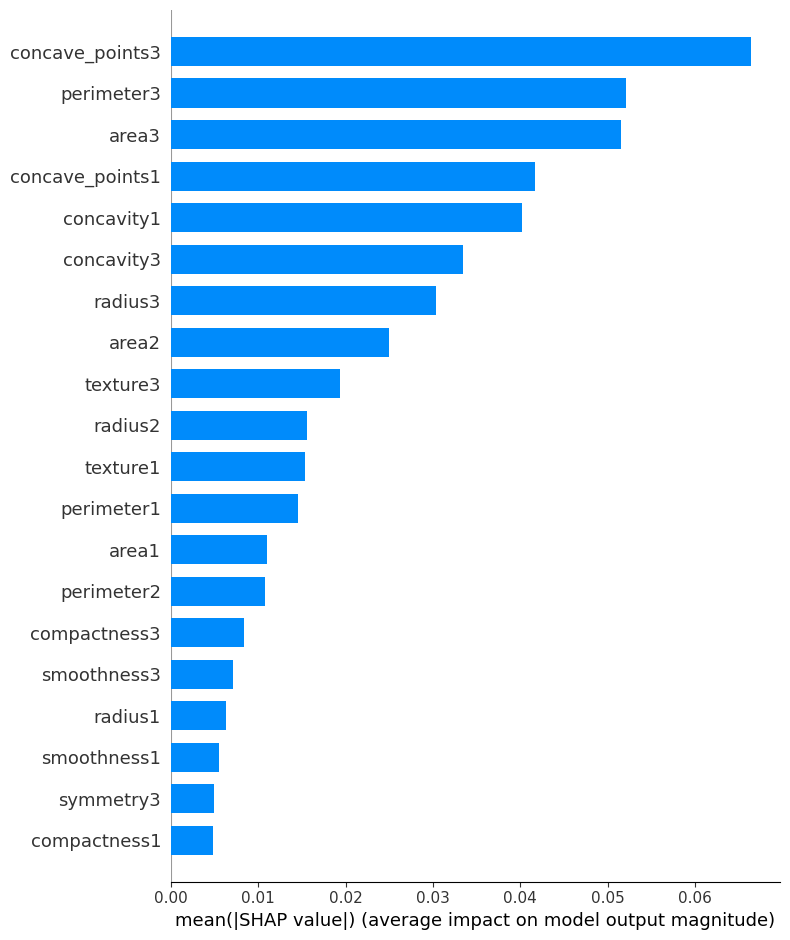

In [71]:
shap.summary_plot(shap_values_dt[..., 1], X_test, plot_type="bar", feature_names=X.columns)

### 3.4 GradientBoost

In [72]:
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy: ", accuracy_score(y_test, y_pred))
print("Gradient Boosting Classification Report: \n", classification_report(y_test, y_pred))
print("Gradient Boosting Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Gradient Boosting ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Gradient Boosting Accuracy:  0.9532163742690059
Gradient Boosting Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       108
           1       0.97      0.90      0.93        63

    accuracy                           0.95       171
   macro avg       0.96      0.94      0.95       171
weighted avg       0.95      0.95      0.95       171

Gradient Boosting Confusion Matrix: 
 [[106   2]
 [  6  57]]
Gradient Boosting ROC AUC Score:  0.943121693121693


#### 3.4.1 Grid Search

In [16]:
# grid search for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gb = GradientBoostingClassifier()
grid_search_gb = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')
grid_search_gb.fit(X_train, y_train)
best_gb = grid_search_gb.best_estimator_
print("Best Gradient Boosting parameters: ", grid_search_gb.best_params_)

Best Gradient Boosting parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [23]:
gb = GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.2, max_depth=5, min_samples_split=10, min_samples_leaf=4)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy: ", accuracy_score(y_test, y_pred))
print("Gradient Boosting Classification Report: \n", classification_report(y_test, y_pred))
print("Gradient Boosting Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Gradient Boosting ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Gradient Boosting Accuracy:  0.9649122807017544
Gradient Boosting Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       108
           1       0.97      0.94      0.95        63

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171

Gradient Boosting Confusion Matrix: 
 [[106   2]
 [  4  59]]
Gradient Boosting ROC AUC Score:  0.958994708994709


#### 3.4.2 Mean Columns

In [ ]:
# fit and predict with only mean columns
gb = GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.2, max_depth=5, min_samples_split=10, min_samples_leaf=4)
gb.fit(X_train_mean, y_train_mean)
y_pred_mean = gb.predict(X_test_mean)
print("Gradient Boosting Accuracy: ", accuracy_score(y_test_mean, y_pred_mean))
print("Gradient Boosting Classification Report: \n", classification_report(y_test_mean, y_pred_mean))
print("Gradient Boosting Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_mean))
print("Gradient Boosting ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_mean))

Gradient Boosting Accuracy:  0.9473684210526315
Gradient Boosting Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

Gradient Boosting Confusion Matrix: 
 [[102   6]
 [  3  60]]
Gradient Boosting ROC AUC Score:  0.9484126984126984


#### 3.4.3 Stratified K Fold

In [31]:
acc_gb, auc_gb = evaluate_model_cv(GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.2, max_depth=5, min_samples_split=10, min_samples_leaf=4),
                  X, y, model_name="Gradient Boosting")


📊 Evaluating Gradient Boosting with 5-Fold Stratified CV
Fold 1 Accuracy: 0.9737, AUC: 0.9697
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Fold 2 Accuracy: 0.9386, AUC: 0.9232
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        71
           1       0.97      0.86      0.91        43

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

Fold 3 Accuracy: 0.9561, AUC: 0.9405
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy 

#### 3.4.4 Shap

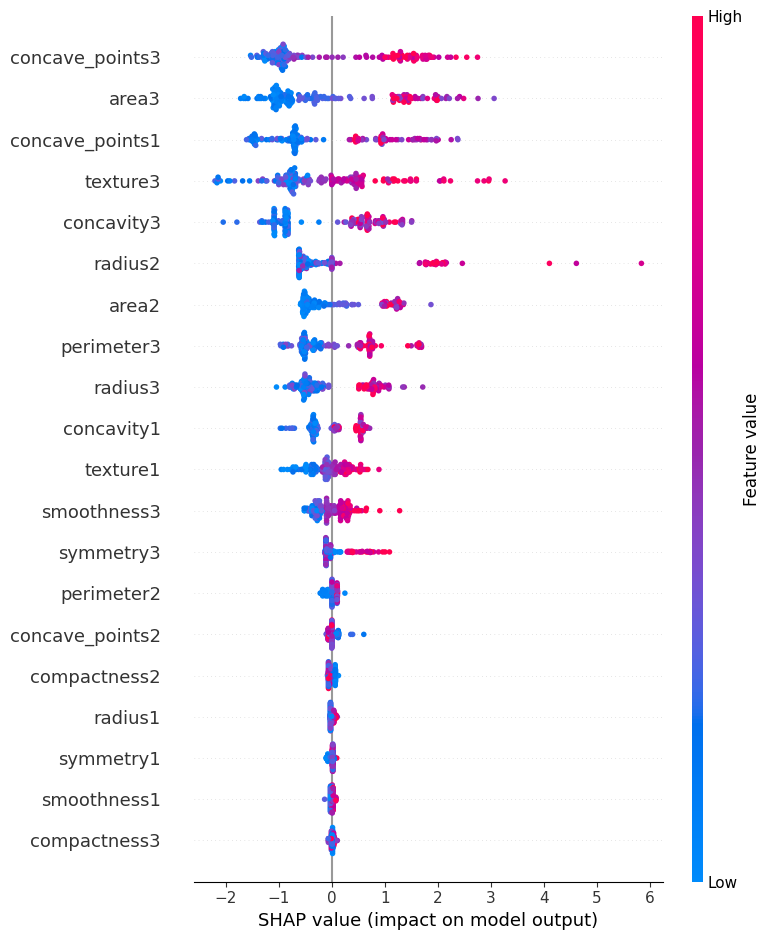

In [79]:
# Create SHAP explainer for the model
explainer_gb = shap.Explainer(gb, X_train)
shap_values_gb = explainer_gb(X_test, check_additivity=False)

# Plot summary of feature importance
shap.summary_plot(shap_values_gb, X_test, feature_names=X.columns)  # class 1 = malignant

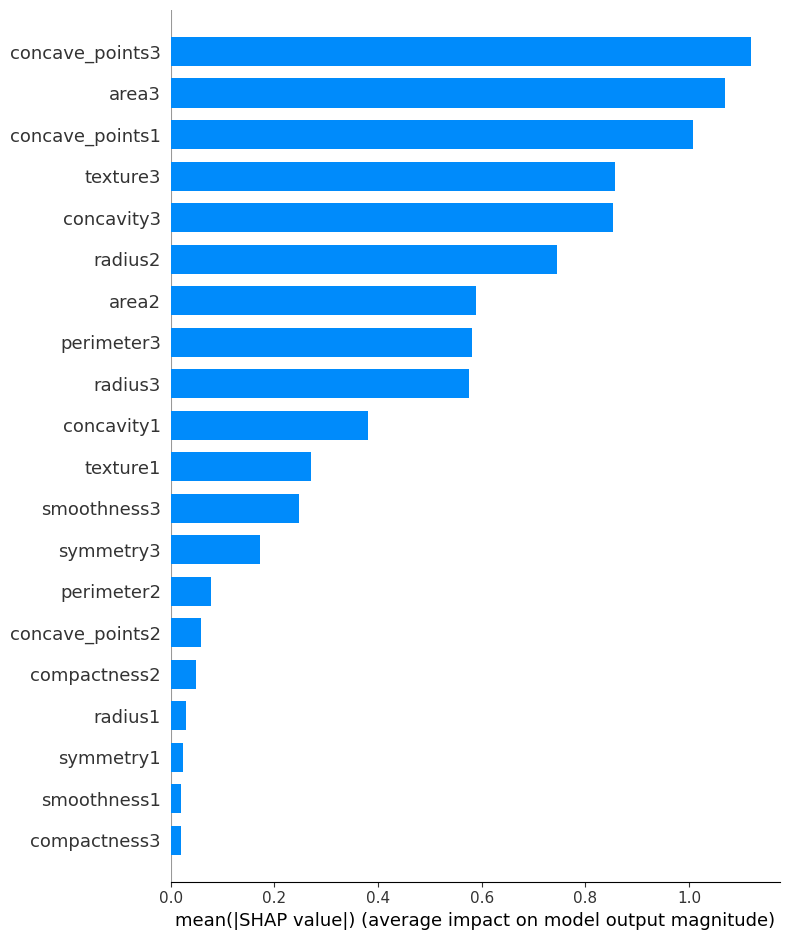

In [80]:
shap.summary_plot(shap_values_gb, X_test, plot_type="bar", feature_names=X.columns)

### 3.5 SVM

In [ ]:
# grid search for hyperparameter tuning
# took over 16 hours to run
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}
svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search_svc.fit(X_train, y_train)
best_svc = grid_search_svc.best_estimator_
print("Best SVC parameters: ", grid_search_svc.best_params_)

In [13]:
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print("SVC Accuracy: ", accuracy_score(y_test, y_pred))
print("SVC Classification Report: \n", classification_report(y_test, y_pred))
print("SVC Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("SVC ROC AUC Score: ", roc_auc_score(y_test, y_pred))

SVC Accuracy:  0.9766081871345029
SVC Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       108
           1       0.97      0.97      0.97        63

    accuracy                           0.98       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171

SVC Confusion Matrix: 
 [[106   2]
 [  2  61]]
SVC ROC AUC Score:  0.974867724867725


#### 3.5.1 Mean Columns

In [ ]:
# fit and predict with only mean columns
svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train_mean, y_train_mean)
y_pred_mean = svc.predict(X_test_mean)
print("SVC Accuracy: ", accuracy_score(y_test_mean, y_pred_mean))
print("SVC Classification Report: \n", classification_report(y_test_mean, y_pred_mean))
print("SVC Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_mean))
print("SVC ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_mean))

SVC Accuracy:  0.9590643274853801
SVC Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       108
           1       0.95      0.94      0.94        63

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171

SVC Confusion Matrix: 
 [[105   3]
 [  4  59]]
SVC ROC AUC Score:  0.9543650793650793


#### 3.5.2 Stratified K Fold

In [32]:
acc_svm, auc_svm = evaluate_model_cv(SVC(kernel='linear', random_state=42),
                  X, y, model_name="SVM")


📊 Evaluating SVM with 5-Fold Stratified CV
Fold 1 Accuracy: 0.9912, AUC: 0.9930
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.98      1.00      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Fold 2 Accuracy: 0.9386, AUC: 0.9278
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        71
           1       0.95      0.88      0.92        43

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

Fold 3 Accuracy: 0.9561, AUC: 0.9454
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97      0.90      0.94        42

    accuracy               

#### 3.5.3 SHAP

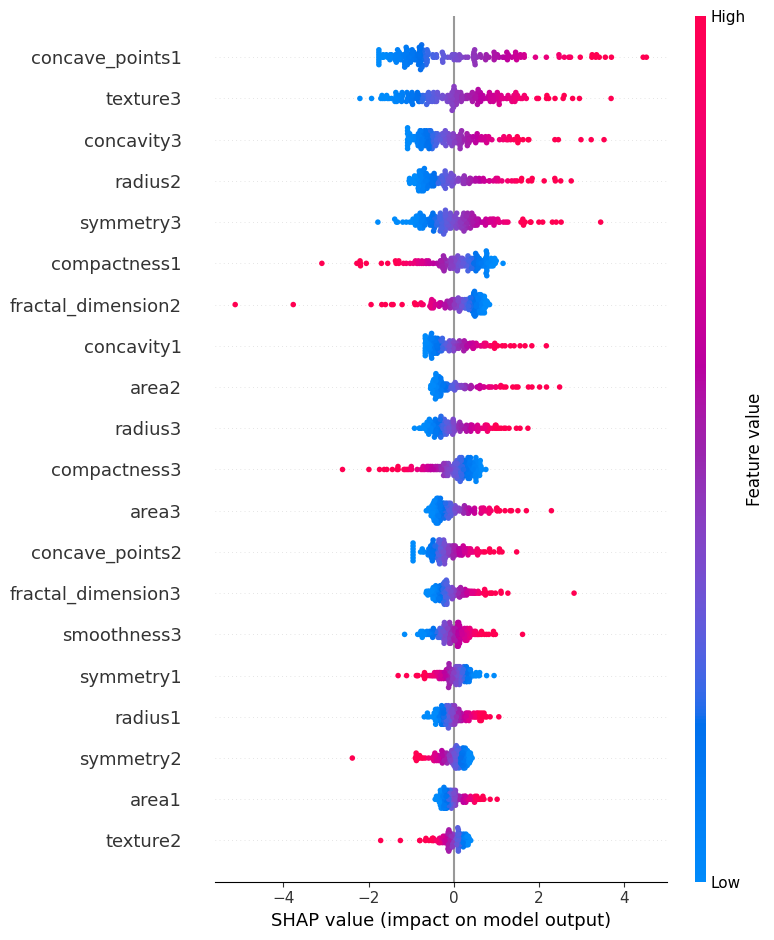

In [15]:
# Create SHAP explainer for the model
explainer_gb = shap.Explainer(svc, X_train)
shap_values_gb = explainer_gb(X_test)

# Plot summary of feature importance
shap.summary_plot(shap_values_gb, X_test, feature_names=X.columns)  # class 1 = malignant

### 3.6 Ensemble

In [25]:
# ensemble model with the best 3 performing models
estimators = [
    ('lr', LogisticRegression(max_iter=1000, C=100, penalty='l1', solver='liblinear')),
    ('svr', make_pipeline(StandardScaler(),
                          SVC(kernel='linear', random_state=42))),
    ('gb', GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.2, max_depth=5, min_samples_split=10, min_samples_leaf=4)),
]
ensemble = StackingClassifier(
    estimators=estimators, final_estimator=DecisionTreeClassifier()
)
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
print("Ensemble Accuracy: ", accuracy_score(y_test, y_pred))
print("Ensemble Classification Report: \n", classification_report(y_test, y_pred))
print("Ensemble Confusion Matrix: \n", confusion_matrix(y_test, y_pred))
print("Ensemble ROC AUC Score: ", roc_auc_score(y_test, y_pred))

Ensemble Accuracy:  0.9415204678362573
Ensemble Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       108
           1       0.91      0.94      0.92        63

    accuracy                           0.94       171
   macro avg       0.93      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

Ensemble Confusion Matrix: 
 [[102   6]
 [  4  59]]
Ensemble ROC AUC Score:  0.9404761904761905


## 4. PCA

In [6]:
# Apply PCA
pca = PCA(n_components=X.shape[1])  # Adjust n_components as needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca.fit(X_train_scaled)

# Print explained variance ratio
print("Explained Variance Ratio: ", pca.explained_variance_ratio_)

loadings = pd.DataFrame(pca.components_.T,  # Transpose so rows = features
                        columns=[f'PC{i+1}' for i in range(X.shape[1])],
                        index=X.columns)
top_pc1_features = loadings['PC1'].abs().sort_values(ascending=False).head(5)
print(top_pc1_features)

Explained Variance Ratio:  [4.33719857e-01 1.86459837e-01 1.02474069e-01 6.50744513e-02
 5.75067087e-02 4.02991624e-02 2.39013824e-02 1.59085330e-02
 1.33732272e-02 1.23822783e-02 1.10294519e-02 9.52260295e-03
 8.09379596e-03 4.94489615e-03 3.08781915e-03 2.32875017e-03
 1.83146292e-03 1.65822395e-03 1.52155237e-03 1.14083722e-03
 8.65363427e-04 7.81181405e-04 6.35565225e-04 5.48594670e-04
 4.04961949e-04 2.25708459e-04 2.08679365e-04 4.88460557e-05
 1.89030796e-05 3.29703451e-06]
concave_points1    0.264040
concavity1         0.259403
concave_points3    0.251871
perimeter3         0.239648
compactness1       0.237848
Name: PC1, dtype: float64


In [19]:
# Apply PCA
pca_mean = PCA(n_components=X_train_mean.shape[1])  # Adjust n_components as needed
scaler_mean = StandardScaler()
X_train_mean_scaled = scaler_mean.fit_transform(X_train_mean)
X_test_mean_scaled = scaler_mean.transform(X_test_mean)
pca_mean.fit(X_train_mean_scaled)

# Print explained variance ratio
print("Explained Variance Ratio: ", pca_mean.explained_variance_ratio_)

loadings_mean = pd.DataFrame(pca_mean.components_.T,  # Transpose so rows = features
                        columns=[f'PC{i+1}' for i in range(X_train_mean.shape[1])],
                        index=X_train_mean.columns)
top_pc1_features_mean = loadings_mean['PC1'].abs().sort_values(ascending=False).head(5)
print(top_pc1_features_mean)

Explained Variance Ratio:  [5.38809424e-01 2.58690578e-01 8.87866463e-02 5.02965437e-02
 3.76387987e-02 1.25419014e-02 8.64693205e-03 3.38874024e-03
 1.17190550e-03 2.85303370e-05]
concave_points1    0.421475
concavity1         0.396869
perimeter1         0.375879
area1              0.364076
radius1            0.363441
Name: PC1, dtype: float64


### 4.1 PCA on Logistic Regression

In [8]:
# Update models to use PCA-transformed data
lr_pca = LogisticRegression(max_iter=1000, C=100, penalty='l1', solver='liblinear')
lr_pca.fit(X_train_scaled, y_train)
y_pred_lr = lr_pca.predict(X_test_scaled)

print("LR Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("LR Classification Report: \n", classification_report(y_test, y_pred_lr))
print("LR Confusion Matrix: \n", confusion_matrix(y_test, y_pred_lr))
print("LR ROC AUC Score: ", roc_auc_score(y_test, y_pred_lr))

LR Accuracy:  0.9473684210526315
LR Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

LR Confusion Matrix: 
 [[102   6]
 [  3  60]]
LR ROC AUC Score:  0.9484126984126984


In [20]:
# fit and predict with only mean columns
lr_pca_mean = LogisticRegression(max_iter=1000, C=100, penalty='l1', solver='liblinear')
lr_pca_mean.fit(X_train_mean_scaled, y_train_mean)
y_pred_lr_mean = lr_pca_mean.predict(X_test_mean_scaled)

print("LR Accuracy: ", accuracy_score(y_test_mean, y_pred_lr_mean))
print("LR Classification Report: \n", classification_report(y_test_mean, y_pred_lr_mean))
print("LR Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_lr_mean))
print("LR ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_lr_mean))

LR Accuracy:  0.9415204678362573
LR Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

LR Confusion Matrix: 
 [[103   5]
 [  5  58]]
LR ROC AUC Score:  0.9371693121693121


### 4.2 PCA on Gradient Boosting

In [10]:
gb_pca = GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.2, max_depth=5, min_samples_split=10, min_samples_leaf=4)
gb_pca.fit(X_train_scaled, y_train)
y_pred_gb = gb_pca.predict(X_test_scaled)
print("GB Accuracy: ", accuracy_score(y_test, y_pred_gb))
print("GB Classification Report: \n", classification_report(y_test, y_pred_gb))
print("GB Confusion Matrix: \n", confusion_matrix(y_test, y_pred_gb))
print("GB ROC AUC Score: ", roc_auc_score(y_test, y_pred_gb))

GB Accuracy:  0.9532163742690059
GB Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       108
           1       0.95      0.92      0.94        63

    accuracy                           0.95       171
   macro avg       0.95      0.95      0.95       171
weighted avg       0.95      0.95      0.95       171

GB Confusion Matrix: 
 [[105   3]
 [  5  58]]
GB ROC AUC Score:  0.9464285714285714


In [22]:
# fit and predict with only mean columns
gb_pca_mean = GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.2, max_depth=5, min_samples_split=10, min_samples_leaf=4)
gb_pca_mean.fit(X_train_mean_scaled, y_train_mean)
y_pred_gb_mean = gb_pca_mean.predict(X_test_mean_scaled)
print("GB Accuracy: ", accuracy_score(y_test_mean, y_pred_gb_mean))
print("GB Classification Report: \n", classification_report(y_test_mean, y_pred_gb_mean))
print("GB Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_gb_mean))
print("GB ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_gb_mean))

GB Accuracy:  0.9473684210526315
GB Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       108
           1       0.91      0.95      0.93        63

    accuracy                           0.95       171
   macro avg       0.94      0.95      0.94       171
weighted avg       0.95      0.95      0.95       171

GB Confusion Matrix: 
 [[102   6]
 [  3  60]]
GB ROC AUC Score:  0.9484126984126984


### 4.3 PCA on SVM

In [11]:
svc_pca = SVC(kernel='linear', random_state=42)
svc_pca.fit(X_train_scaled, y_train)
y_pred_svc = svc_pca.predict(X_test_scaled)
print("SVC Accuracy: ", accuracy_score(y_test, y_pred_svc))
print("SVC Classification Report: \n", classification_report(y_test, y_pred_svc))
print("SVC Confusion Matrix: \n", confusion_matrix(y_test, y_pred_svc))
print("SVC ROC AUC Score: ", roc_auc_score(y_test, y_pred_svc))

SVC Accuracy:  0.9824561403508771
SVC Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       108
           1       0.98      0.97      0.98        63

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171

SVC Confusion Matrix: 
 [[107   1]
 [  2  61]]
SVC ROC AUC Score:  0.9794973544973545


In [23]:
# fit and predict with only mean columns
svc_pca_mean = SVC(kernel='linear', random_state=42)
svc_pca_mean.fit(X_train_mean_scaled, y_train_mean)
y_pred_svm_mean = svc_pca_mean.predict(X_test_mean_scaled)
print("SVC Accuracy: ", accuracy_score(y_test_mean, y_pred_svm_mean))
print("SVC Classification Report: \n", classification_report(y_test_mean, y_pred_svm_mean))
print("SVC Confusion Matrix: \n", confusion_matrix(y_test_mean, y_pred_svm_mean))
print("SVC ROC AUC Score: ", roc_auc_score(y_test_mean, y_pred_svm_mean))

SVC Accuracy:  0.9415204678362573
SVC Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       108
           1       0.92      0.92      0.92        63

    accuracy                           0.94       171
   macro avg       0.94      0.94      0.94       171
weighted avg       0.94      0.94      0.94       171

SVC Confusion Matrix: 
 [[103   5]
 [  5  58]]
SVC ROC AUC Score:  0.9371693121693121


### 5.1 Logistic Regression

In [27]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=1000, C=100, penalty='l1', solver='liblinear'))
    ])

    pipeline.fit(X_train_fold, y_train_fold)
    y_pred = pipeline.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, y_pred)
    auc_score = roc_auc_score(y_test_fold, y_pred)

    accuracies.append(acc)
    aucs.append(auc_score)

    print("LR Fold Accuracy:", acc)
    print("LR Fold AUC:", auc_score)
    print(classification_report(y_test_fold, y_pred))

print("\nLR Average Accuracy:", np.mean(accuracies))
print("LR Average AUC:", np.mean(aucs))

LR Fold Accuracy: 0.9298245614035088
LR Fold AUC: 0.9299050114641335
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        71
           1       0.89      0.93      0.91        43

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114

LR Fold Accuracy: 0.956140350877193
LR Fold AUC: 0.9510317720275139
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

LR Fold Accuracy: 0.9385964912280702
LR Fold AUC: 0.9315476190476191
              precision    recall  f1-score   support

           0       0.95      0.96      0.95        72
           1       0.93      0.

### 5.2 Random Forest

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('rf', RandomForestClassifier(n_estimators=50, random_state=42, max_depth=10, min_samples_split=5, min_samples_leaf=1, max_features='sqrt'))
    ])

    pipeline.fit(X_train_fold, y_train_fold)
    y_pred = pipeline.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, y_pred)
    auc_score = roc_auc_score(y_test_fold, y_pred)

    accuracies.append(acc)
    aucs.append(auc_score)

    print("RF Fold Accuracy:", acc)
    print("RF Fold AUC:", auc_score)
    print(classification_report(y_test_fold, y_pred))

print("\nRF Average Accuracy:", np.mean(accuracies))
print("RF Average AUC:", np.mean(aucs))

RF Fold Accuracy: 0.9649122807017544
RF Fold AUC: 0.9672453324598755
              precision    recall  f1-score   support

           0       0.99      0.96      0.97        71
           1       0.93      0.98      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

RF Fold Accuracy: 0.9385964912280702
RF Fold AUC: 0.9231903046184081
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        71
           1       0.97      0.86      0.91        43

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

RF Fold Accuracy: 0.9473684210526315
RF Fold AUC: 0.933531746031746
              precision    recall  f1-score   support

           0       0.93      0.99      0.96        72
           1       0.97      0.

### 5.3 Decision Tree

In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dt', DecisionTreeClassifier(random_state=42, min_samples_split=5, min_samples_leaf=4, max_features='log2', criterion='gini'))
    ])

    pipeline.fit(X_train_fold, y_train_fold)
    y_pred = pipeline.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, y_pred)
    auc_score = roc_auc_score(y_test_fold, y_pred)

    accuracies.append(acc)
    aucs.append(auc_score)

    print("DT Fold Accuracy:", acc)
    print("DT Fold AUC:", auc_score)
    print(classification_report(y_test_fold, y_pred))

print("\nDT Average Accuracy:", np.mean(accuracies))
print("DT Average AUC:", np.mean(aucs))

DT Fold Accuracy: 0.9385964912280702
DT Fold AUC: 0.9461185718964953
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        71
           1       0.88      0.98      0.92        43

    accuracy                           0.94       114
   macro avg       0.93      0.95      0.94       114
weighted avg       0.94      0.94      0.94       114

DT Fold Accuracy: 0.9122807017543859
DT Fold AUC: 0.8883065836881756
              precision    recall  f1-score   support

           0       0.89      0.99      0.93        71
           1       0.97      0.79      0.87        43

    accuracy                           0.91       114
   macro avg       0.93      0.89      0.90       114
weighted avg       0.92      0.91      0.91       114

DT Fold Accuracy: 0.9298245614035088
DT Fold AUC: 0.9097222222222224
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        72
           1       0.97      0

### 5.4 GradientBoost

In [30]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gb', GradientBoostingClassifier(n_estimators=200, random_state=42, learning_rate=0.2, max_depth=5, min_samples_split=10, min_samples_leaf=4))
    ])

    pipeline.fit(X_train_fold, y_train_fold)
    y_pred = pipeline.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, y_pred)
    auc_score = roc_auc_score(y_test_fold, y_pred)

    accuracies.append(acc)
    aucs.append(auc_score)

    print("GB Fold Accuracy:", acc)
    print("GB Fold AUC:", auc_score)
    print(classification_report(y_test_fold, y_pred))

print("\nGB Average Accuracy:", np.mean(accuracies))
print("GB Average AUC:", np.mean(aucs))

GB Fold Accuracy: 0.9736842105263158
GB Fold AUC: 0.9697019325253848
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

GB Fold Accuracy: 0.9385964912280702
GB Fold AUC: 0.9231903046184081
              precision    recall  f1-score   support

           0       0.92      0.99      0.95        71
           1       0.97      0.86      0.91        43

    accuracy                           0.94       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

GB Fold Accuracy: 0.956140350877193
GB Fold AUC: 0.9404761904761905
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.

### 5.5 SVM

In [31]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
aucs = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='linear', random_state=42))
    ])

    pipeline.fit(X_train_fold, y_train_fold)
    y_pred = pipeline.predict(X_test_fold)

    acc = accuracy_score(y_test_fold, y_pred)
    auc_score = roc_auc_score(y_test_fold, y_pred)

    accuracies.append(acc)
    aucs.append(auc_score)

    print("SVC Fold Accuracy:", acc)
    print("SVC Fold AUC:", auc_score)
    print(classification_report(y_test_fold, y_pred))

print("\nSVC Average Accuracy:", np.mean(accuracies))
print("SVC Average AUC:", np.mean(aucs))

SVC Fold Accuracy: 0.9912280701754386
SVC Fold AUC: 0.9929577464788732
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        71
           1       0.98      1.00      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

SVC Fold Accuracy: 0.9385964912280702
SVC Fold AUC: 0.9277759580740256
              precision    recall  f1-score   support

           0       0.93      0.97      0.95        71
           1       0.95      0.88      0.92        43

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

SVC Fold Accuracy: 0.956140350877193
SVC Fold AUC: 0.945436507936508
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        72
           1       0.97   

## 5. Evaluation

### 5.1 PCA ROC Curve

In [12]:
# Plot ROC curve
def plot_roc_curve(y_test, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

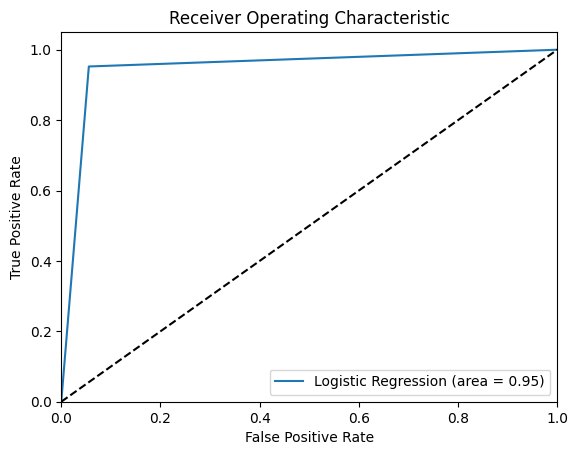

In [13]:
# Logistic Regression
plot_roc_curve(y_test, y_pred_lr, 'Logistic Regression')

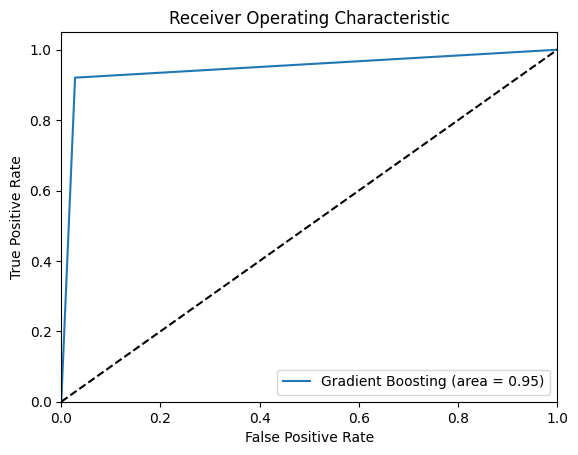

In [14]:
# Gradient Boosting
plot_roc_curve(y_test, y_pred_gb, 'Gradient Boosting')

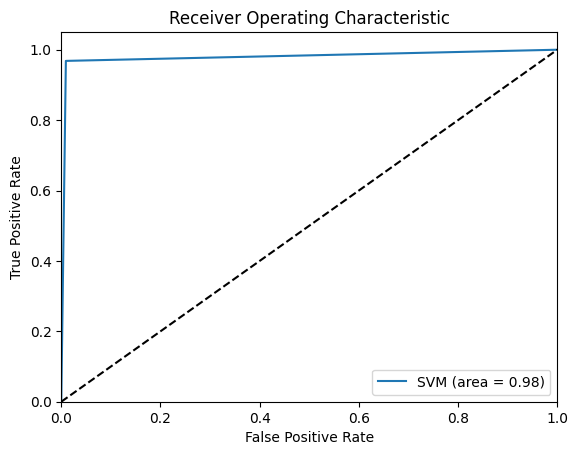

In [15]:
# SVM
plot_roc_curve(y_test, y_pred_svc, 'SVM')

### 5.2 Accuracy Curves

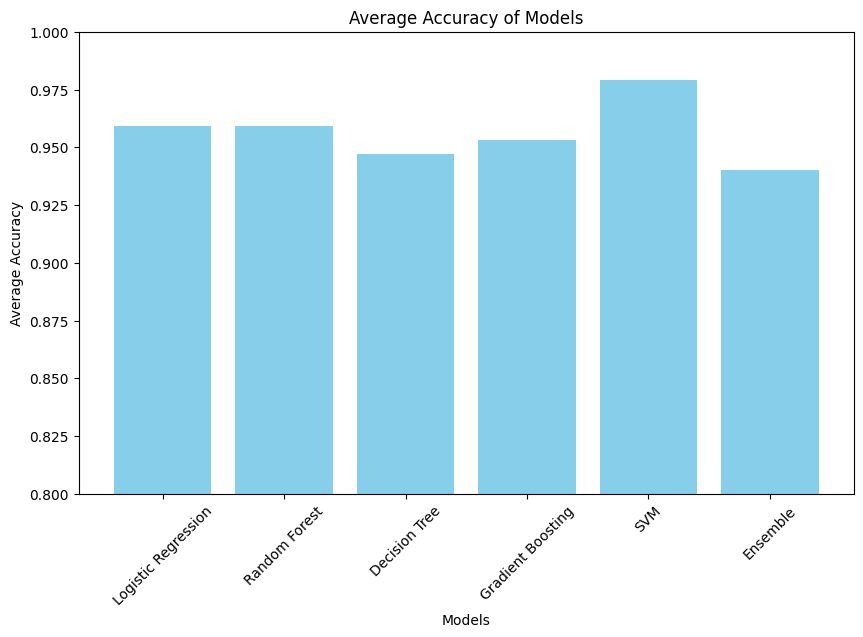

In [ ]:
# Define model names and their average accuracies
model_names = ["Logistic Regression", "Random Forest", "Decision Tree", "Gradient Boosting", "SVM", "Ensemble"]
average_accuracies = [0.964, 0.964, 0.947, 0.953, 0.982, 0.940]  # Replace with actual average accuracies

# Plot the average accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_names, average_accuracies, color='skyblue')
plt.ylim(0.8, 1.0)
plt.title("Average Accuracy of Models")
plt.xlabel("Models")
plt.ylabel("Average Accuracy")
plt.xticks(rotation=45)
plt.show()

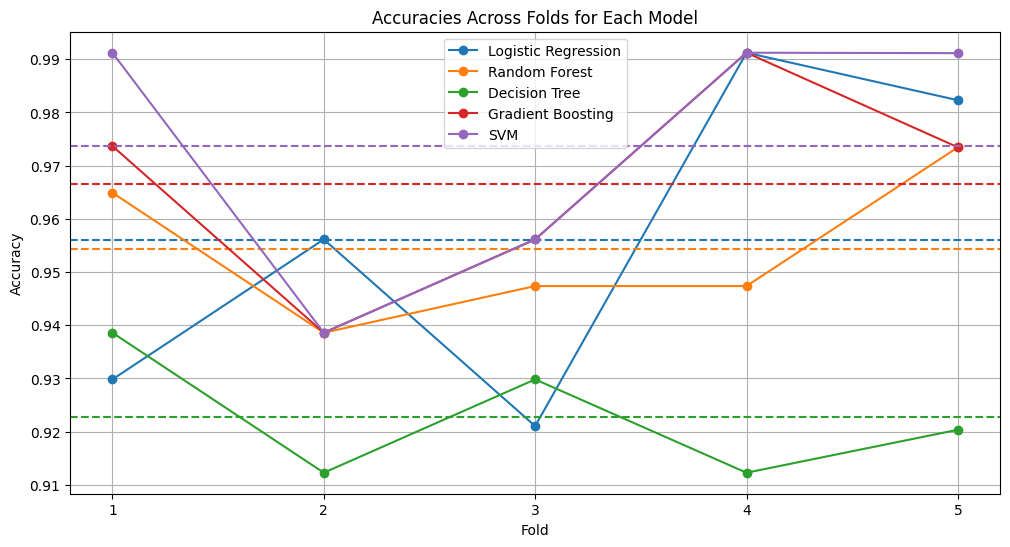

In [41]:
# Define model names and their accuracies
models = ["Logistic Regression", "Random Forest", "Decision Tree", "Gradient Boosting", "SVM"]
accuracies = [acc_lr, acc_rf, acc_dt, acc_gb, acc_svm]  # Replace with your actual accuracy lists

# Plotting accuracies
plt.figure(figsize=(12, 6))
for i, model in enumerate(models):
    # Plot the accuracy line for each fold
    line, = plt.plot(range(1, len(accuracies[i]) + 1), accuracies[i], marker='o', label=model)
    # Plot the mean accuracy line with the same color as the model's line
    plt.axhline(y=np.mean(accuracies[i]), color=line.get_color(), linestyle='--')

plt.title("Accuracies Across Folds for Each Model")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.xticks(range(1, len(accuracies[0]) + 1))
plt.legend()
plt.grid()
plt.show()

### 5.3 AUC Curves

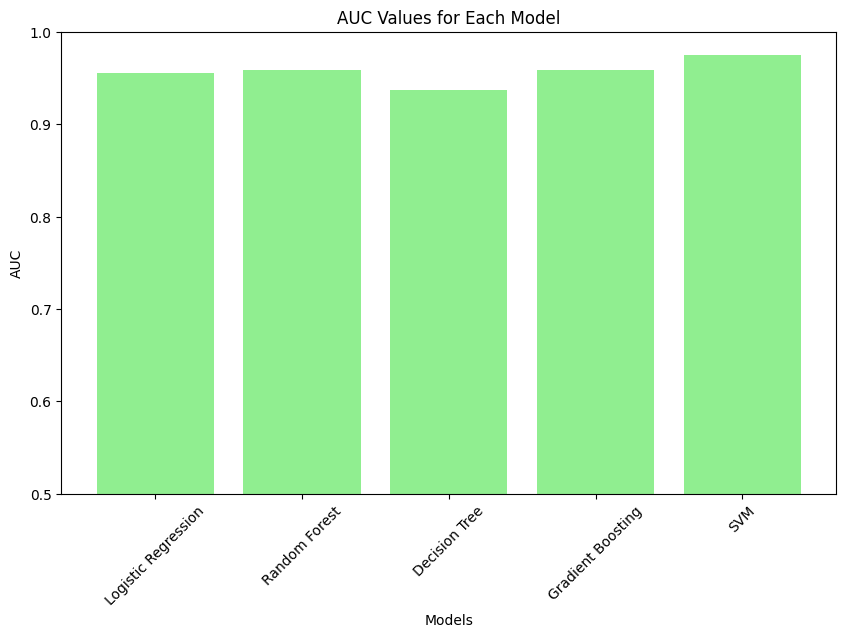

In [25]:
auc_values = {
    "Logistic Regression": roc_auc_score(y_test, lr.predict(X_test)),
    "Random Forest": roc_auc_score(y_test, rf.predict(X_test)),
    "Decision Tree": roc_auc_score(y_test, dt.predict(X_test)),
    "Gradient Boosting": roc_auc_score(y_test, gb.predict(X_test)),
    "SVM": roc_auc_score(y_test, svc.predict(X_test))
}

# Plot the AUC values
plt.figure(figsize=(10, 6))
plt.bar(auc_values.keys(), auc_values.values(), color='lightgreen')
plt.ylim(0.5, 1.0)  # AUC ranges from 0.5 to 1.0
plt.title("AUC Values for Each Model")
plt.xlabel("Models")
plt.ylabel("AUC")
plt.xticks(rotation=45)
plt.show()

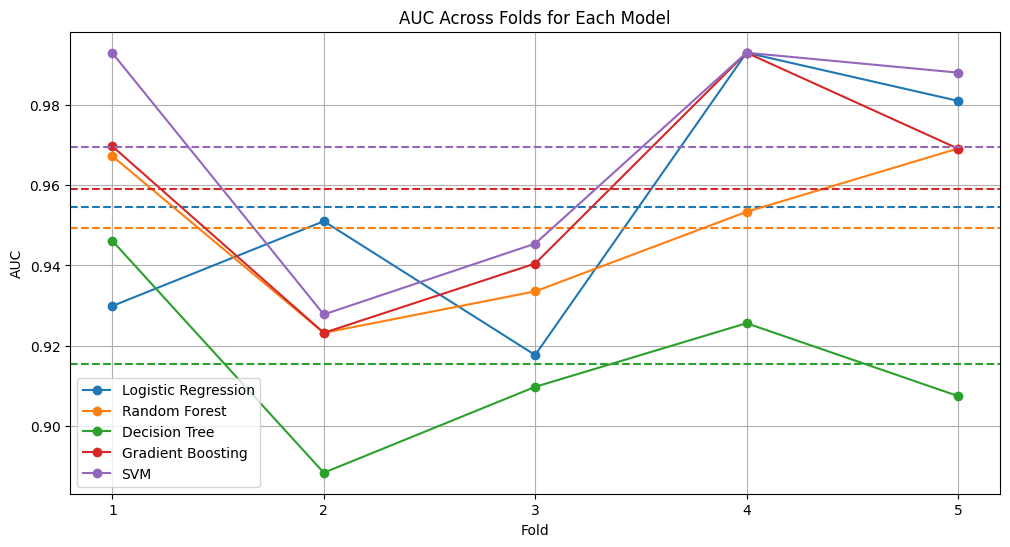

In [42]:
# Define model names and their accuracies
models = ["Logistic Regression", "Random Forest", "Decision Tree", "Gradient Boosting", "SVM"]
auc = [auc_lr, auc_rf, auc_dt, auc_gb, auc_svm]  # Replace with your actual accuracy lists

# Plotting accuracies
plt.figure(figsize=(12, 6))
for i, model in enumerate(models):
    # Plot the accuracy line for each fold
    line, = plt.plot(range(1, len(auc[i]) + 1), auc[i], marker='o', label=model)
    # Plot the mean accuracy line with the same color as the model's line
    plt.axhline(y=np.mean(auc[i]), color=line.get_color(), linestyle='--')

plt.title("AUC Across Folds for Each Model")
plt.xlabel("Fold")
plt.ylabel("AUC")
plt.xticks(range(1, len(auc[0]) + 1))
plt.legend()
plt.grid()
plt.show()